In [7]:
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import obspy
from obspy.core.event import read_events

import seisbench
import seisbench.data as sbd
import seisbench.util as sbu
import numpy as np



# Creating a dataset

In [2]:
input_path = "/net/pr2/projects/plgrid/plggeposai/datasets/bogdanka"
catalog_path = "/net/pr2/projects/plgrid/plggeposai/datasets/bogdanka/BOIS_all.xml"
output_path = "/net/pr2/projects/plgrid/plggeposai/kmilian/platform-demo-scripts/datasets/bogdanka/seisbench_format"



In [3]:
events = read_events(catalog_path)

/net/pr2/projects/plgrid/plggeposai/mambaforge/envs/eposai/lib/python3.11/site-packages/obspy/io/quakeml/core.py:193: UserWarning: Setting attribute "preferred_description" failed. Value "uncertainty elipse" could not be converted to type "Enum(["horizontal uncertainty", "uncertainty ellipse", "confidence ellipsoid"])". The attribute "preferred_description" will not be set and will be missing in the resulting object.
  warnings.warn(msg)


### Define train/dev/test split

In [4]:
def get_event_params(event): 

    
    origin = event.preferred_origin()
    if origin is None:
        return {}

    mag = event.preferred_magnitude()

    source_id = str(event.resource_id)

    event_params = {
        "source_id": source_id,
        "source_origin_uncertainty_sec": origin.time_errors["uncertainty"],
        "source_latitude_deg": origin.latitude,
        "source_latitude_uncertainty_km": origin.latitude_errors["uncertainty"],
        "source_longitude_deg": origin.longitude,
        "source_longitude_uncertainty_km": origin.longitude_errors["uncertainty"],
        "source_depth_km": origin.depth / 1e3,
        "source_depth_uncertainty_km": origin.depth_errors["uncertainty"] / 1e3 if origin.depth_errors["uncertainty"] is not None else None,
    }

    if mag is not None:
        event_params["source_magnitude"] = mag.mag
        event_params["source_magnitude_uncertainty"] = mag.mag_errors["uncertainty"]
        event_params["source_magnitude_type"] = mag.magnitude_type
        event_params["source_magnitude_author"] = mag.creation_info.agency_id if mag.creation_info is not None else None
        
    return event_params


def get_trace_params(pick):
    net = pick.waveform_id.network_code
    sta = pick.waveform_id.station_code

    trace_params = {
        "station_network_code": net,
        "station_code": sta,
        "trace_channel": pick.waveform_id.channel_code,
        "station_location_code": pick.waveform_id.location_code,
        "time": pick.time
    }

    return trace_params


def get_trace_path(input_path, trace_params):

    year = trace_params["time"].year
    day_of_year = pd.Timestamp(str(trace_params["time"])).day_of_year
    net = trace_params["station_network_code"]
    station = trace_params["station_code"]
    tr_channel = trace_params["trace_channel"]

    path = f"{input_path}/{year}/{net}/{station}/{tr_channel}.D/{net}.{station}..{tr_channel}.D.{year}.{day_of_year}"
    return path

In [5]:
def split_events(events, input_path):

    print("Splitting available events into train, dev and test sets ...")
    events_stats = pd.DataFrame()
    events_stats.index.name = "event"
    missing_mseeds = []

    for i, event in enumerate(events):
        #check if mseed exists
        actual_picks = 0
        for pick in event.picks:
            trace_params = get_trace_params(pick)
            trace_path = get_trace_path(input_path, trace_params)
            if os.path.isfile(trace_path):
                actual_picks += 1
            else: 
                missing_mseeds.append(trace_path.split('/'))
                

        events_stats.loc[i, "pick_count"] = len(event.picks)
        events_stats.loc[i, "available_picks"] = actual_picks
        if len(event.picks):
            events_stats.loc[i, "first_peak_time"] = trace_params["time"]

    events_stats['pick_count_cumsum'] = events_stats.pick_count.cumsum()

    train_th = 0.7 * events_stats.pick_count_cumsum.values[-1]
    dev_th = 0.85 * events_stats.pick_count_cumsum.values[-1]

    events_stats['split'] = 'test'
    for i, event in events_stats.iterrows():
        if event['pick_count_cumsum'] < train_th:
            events_stats.loc[i, 'split'] = 'train'
        elif event['pick_count_cumsum'] < dev_th:
            events_stats.loc[i, 'split'] = 'dev'
        else:
            break

    missing_mseeds = pd.DataFrame(np.array(missing_mseeds)[:, -5:], columns=['y', 'n','s','tr','f'])
    missing_mseeds['last_dot'] = missing_mseeds['f'].apply(lambda x: x.rindex('.'))

    for i, row in missing_mseeds.iterrows(): 
        missing_mseeds.loc[i, 'd'] = int(row['f'][row['last_dot']+1:])


    return events_stats, missing_mseeds

In [8]:
events_stats, missing_mseeds = split_events(events, input_path)
events_stats.head()

Splitting available events into train, dev and test sets ...


/net/ascratch/people/plgkmilian/slurm_jobdir/5092284/tmp/ipykernel_248521/649615512.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2018-09-24T14:20:07.521000Z' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  events_stats.loc[i, "first_peak_time"] = trace_params["time"]


pick_count  available_picks              first_peak_time  \
event                                                             
0             0.0              0.0                          NaN   
1            10.0              8.0  2018-09-24T14:20:07.521000Z   
2            10.0             10.0  2018-10-04T21:44:08.474000Z   
3            12.0             10.0  2018-10-05T23:25:45.835000Z   
4            10.0             10.0  2018-10-07T22:02:11.773000Z   

       pick_count_cumsum  split  
event                            
0                    0.0  train  
1                   10.0  train  
2                   20.0  train  
3                   32.0  train  
4                   42.0  train

In [9]:
missing_mseeds.head()

y   n     s     tr                        f  last_dot      d
0  2018  PL  BOG5  EHN.D  PL.BOG5..EHN.D.2018.267        19  267.0
1  2018  PL  BOG5  EHZ.D  PL.BOG5..EHZ.D.2018.267        19  267.0
2  2018  PL  BOG5  EHE.D  PL.BOG5..EHE.D.2018.278        19  278.0
3  2018  PL  BOG5  EHZ.D  PL.BOG5..EHZ.D.2018.278        19  278.0
4  2018  PL  BOG5  EHN.D  PL.BOG5..EHN.D.2018.281        19  281.0

#### Check missing files

<Axes: title={'center': 'Missing mseeds grouped by year and station'}, xlabel='y,s'>

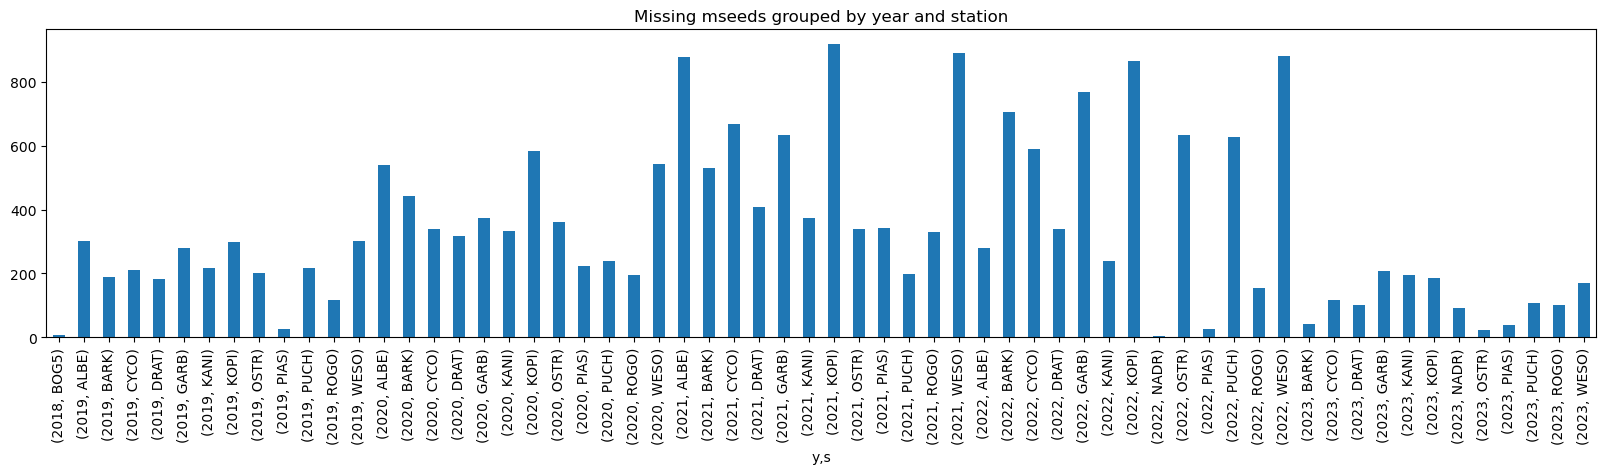

In [10]:
missing_mseeds.groupby(['y','s']).size().plot(kind='bar', figsize=(20,4), title='Missing mseeds grouped by year and station')

In [11]:
missing_mseeds.groupby(['y', 's'])['d'].agg(['min', 'max'])

min    max
y    s                 
2018 BOG5  267.0  281.0
2019 ALBE    2.0   99.0
     BARK   11.0   99.0
     CYCO    2.0   99.0
     DRAT    2.0   99.0
...          ...    ...
2023 OSTR   10.0  149.0
     PIAS   12.0  124.0
     PUCH   10.0  149.0
     ROGO   12.0  149.0
     WESO   10.0  149.0

[62 rows x 2 columns]

s
ALBE    Axes(0.125,0.11;0.775x0.77)
BARK    Axes(0.125,0.11;0.775x0.77)
CYCO    Axes(0.125,0.11;0.775x0.77)
DRAT    Axes(0.125,0.11;0.775x0.77)
GARB    Axes(0.125,0.11;0.775x0.77)
KANI    Axes(0.125,0.11;0.775x0.77)
KOPI    Axes(0.125,0.11;0.775x0.77)
OSTR    Axes(0.125,0.11;0.775x0.77)
PIAS    Axes(0.125,0.11;0.775x0.77)
PUCH    Axes(0.125,0.11;0.775x0.77)
ROGO    Axes(0.125,0.11;0.775x0.77)
WESO    Axes(0.125,0.11;0.775x0.77)
Name: d, dtype: object

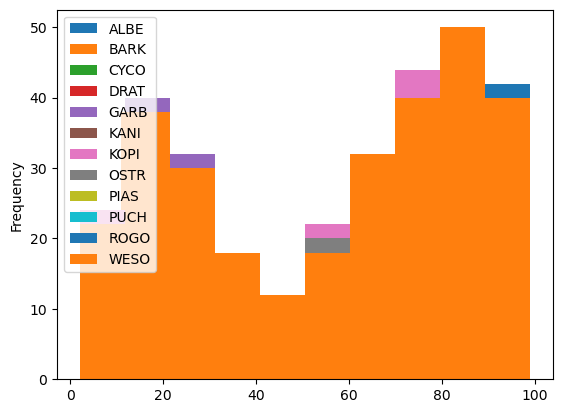

In [106]:
missing_mseeds[missing_mseeds.y=='2019'].groupby(['s'])['d'].plot(kind='hist', legend=True)

In [64]:
missing_mseeds.groupby('y').size()

y
2018       6
2019    2540
2020    4486
2021    6507
2022    6111
2023    1379
dtype: int64

In [17]:
events_stats.shape

(2099, 3)

<Axes: xlabel='event'>

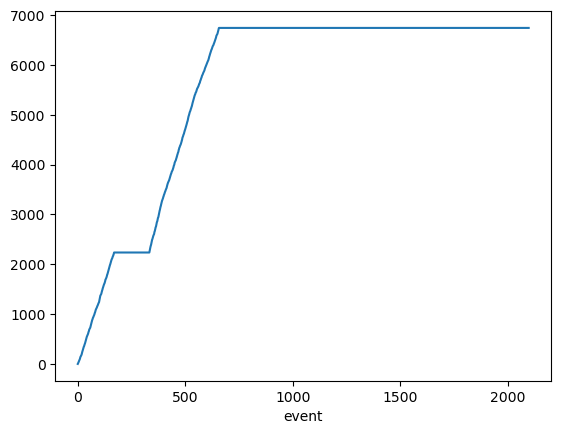

In [18]:
events_stats.pick_count_cumsum.plot()

### Transform mseeds to Seisbench format

In [13]:
def find_trace(pick_time, traces): 
    for tr in traces: 
        if pick_time>tr.stats.endtime: 
            continue
        if pick_time>=tr.stats.starttime: 
            # print(pick_time, " - selected trace: ", tr)
            return tr

    print(pick_time, " no matching trace ")
    return None



In [14]:
def load_trace(input_path, trace_params):
    trace_path = get_trace_path(input_path, trace_params)
    trace, stream = None, None

    if not os.path.isfile(trace_path):
        print(trace_path + " not found")
    else:
        stream = obspy.read(trace_path)
        if len(stream.traces) > 1:
            trace = find_trace(trace_params["time"], stream.traces)
        elif len(stream.traces) == 0:
            print("no data in:", trace_path)
        else:
            trace = stream.traces[0]

    return trace, stream


def load_stream(input_path, trace_params, time_before=60, time_after=60):
    trace_path = get_trace_path(input_path, trace_params)
    sampling_rate, stream = None, None
    pick_time = trace_params["time"]

    if not os.path.isfile(trace_path):
        print(trace_path + " not found")
    else:
        stream = obspy.read(trace_path)
        stream = stream.slice(pick_time - time_before, pick_time + time_after)
        if len(stream.traces) == 0:
            print(f"no data in: {trace_path}")
        else:
            sampling_rate = stream.traces[0].stats.sampling_rate

    return sampling_rate, stream

In [15]:
metadata_path = output_path + "/metadata.csv"
waveforms_path = output_path + "/waveforms.hdf5"
train = 0.7
dev = 0.15
test = 0.15

In [ ]:
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
    }
    for i, event in enumerate(events):
        logger.debug(f"Converting {i} event")
        event_params = get_event_params(event)
        event_params["split"] = events_stats.loc[i, "split"]
        #             b = False

        for pick in event.picks:
            trace_params = get_trace_params(pick)
            sampling_rate, stream = load_stream(input_path, trace_params)
            if stream is None:
                continue

            actual_t_start, data, _ = sbu.stream_to_array(
                stream,
                component_order=writer.data_format["component_order"],
            )

            trace_params["trace_sampling_rate_hz"] = sampling_rate
            trace_params["trace_start_time"] = str(actual_t_start)

            pick_time = obspy.core.utcdatetime.UTCDateTime(trace_params["time"])
            pick_idx = (pick_time - actual_t_start) * sampling_rate

            trace_params[f"trace_{pick.phase_hint}_arrival_sample"] = int(pick_idx)

            writer.add_trace({**event_params, **trace_params}, data)

### Load created dataset

In [6]:
data = sbd.WaveformDataset(output_path, sampling_rate=100)

In [7]:
data

#### Check train/dev/test proportions

In [8]:
all_samples = len(data.train()) + len(data.dev()) + len(data.test())
print("All samples: ", all_samples)
print(f"Training examples: {len(data.train())} {len(data.train())/all_samples * 100:.1f}%" )
print(f"Development examples: {len(data.dev())} {len(data.dev())/all_samples * 100:.1f}%")
print(f"Test examples: {len(data.test())} {len(data.test())/all_samples * 100:.1f} %")

All samples:  6743
Training examples: 4720 70.0%
Development examples: 1009 15.0%
Test examples: 1014 15.0 %


#### Plot converted sample

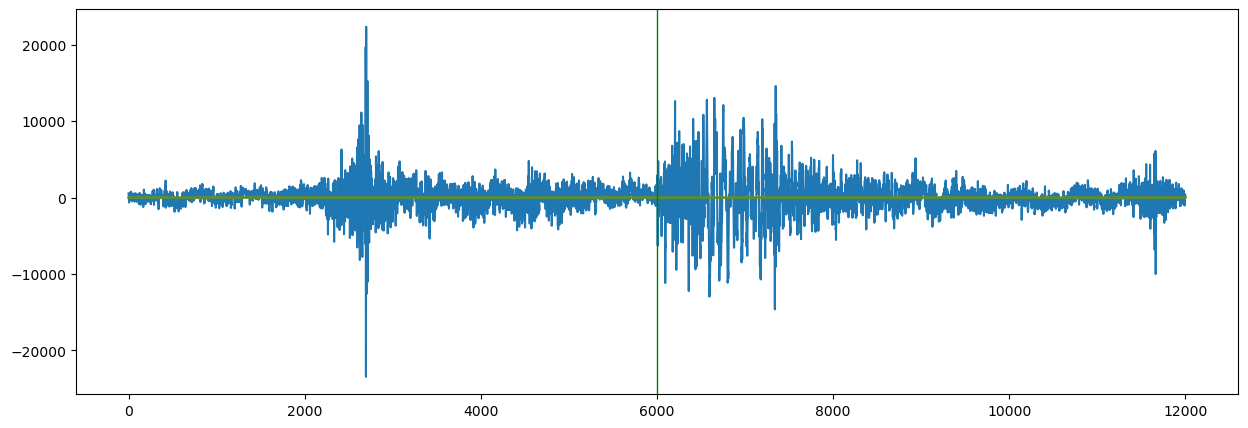

In [9]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)

idx = 0
ax.plot(data.get_waveforms(idx).T)
ax.axvline(data.metadata["trace_Pg_arrival_sample"].iloc[idx], color="green", lw=1)

plt.show()


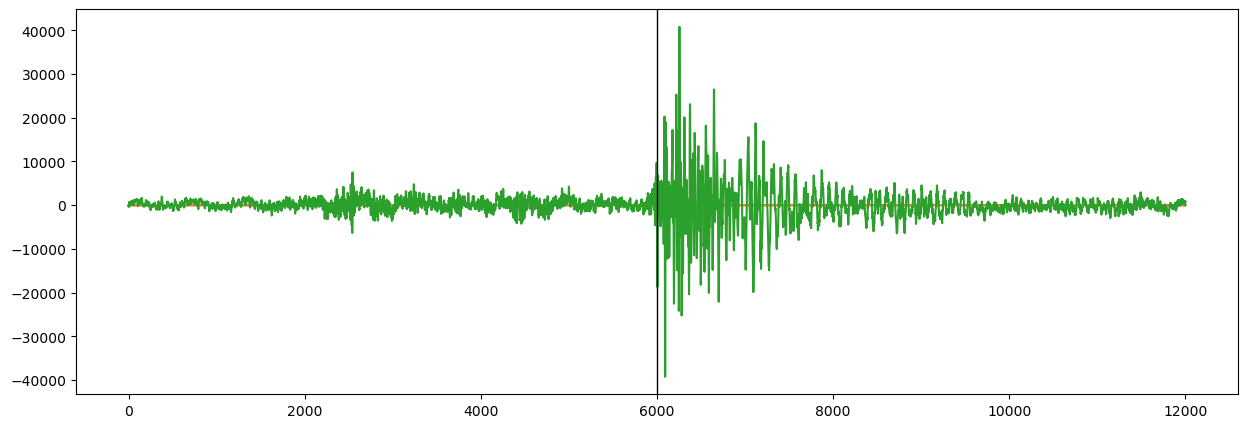

In [18]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
idx = 1
ax.plot(data.get_waveforms(idx).T)
# ax.axvline(data.metadata["trace_Pg_arrival_sample"].iloc[idx], color="green", lw=1)
ax.axvline(data.metadata["trace_Sg_arrival_sample"].iloc[idx], color="black", lw=1)
plt.show()

In [19]:
data.metadata[["trace_Pg_arrival_sample", "trace_Sg_arrival_sample"]]

trace_Pg_arrival_sample  trace_Sg_arrival_sample
0                      5999.0                      NaN
1                         NaN                   5999.0
2                         NaN                   6000.0
3                      5999.0                      NaN
4                      6000.0                      NaN
...                       ...                      ...
6738                      NaN                   5999.0
6739                   5999.0                      NaN
6740                   6000.0                      NaN
6741                      NaN                   5999.0
6742                   5999.0                      NaN

[6743 rows x 2 columns]